# KHOTAA – DFU Classification (Preprocessing & Visual QA)

This notebook is used to:
1. Verify the dataset structure and class distribution.
2. Visualize raw images from each class.
3. Define and validate the preprocessing pipeline (augmentation + normalization).
4. Visually inspect the effect of augmentations to ensure they are clinically reasonable.

## Imports 

In [79]:
import sys, os
import random
import numpy as np
import matplotlib.pyplot as plt

import cv2
from PIL import Image

# PyTorch / Torchvision
import torch
from torchvision import transforms


## 1. Load Dataset Paths Using the Existing Loader

This loader returns:
- `X_paths`: image file paths
- `y_labels`: integer labels (0..3)

We will **not** load all images into memory. We will only load samples for visualization.


In [80]:
PROJECT_ROOT = os.path.abspath(".")
sys.path.insert(0, PROJECT_ROOT)

from models.classification.dataset_loader import SplitFolderDatasetLoader

root_dir = os.path.join(PROJECT_ROOT, "dataset")
loader = SplitFolderDatasetLoader(root_dir=root_dir)

classes = loader.get_classes()

X_train, y_train = loader.load_split_paths("train", shuffle=True)
X_valid, y_valid = loader.load_split_paths("valid", shuffle=False)
X_test, y_test   = loader.load_split_paths("test", shuffle=False)

print(f"Classes: {classes}")
print(f"Split sizes - Train: {len(X_train)}, Valid: {len(X_valid)}, Test: {len(X_test)}")
print(f"Train distribution: {loader.get_class_counts('train')}")
print("Dataset loaded successfully")

[DatasetLoader] Root: c:\Users\sara2\Documents\KHOTAA\dataset
[DatasetLoader] Splits: ['train', 'valid', 'test']
[DatasetLoader] Classes (4): ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']
[DatasetLoader] Split 'train': 9639 images
[DatasetLoader] Split 'valid': 282 images
[DatasetLoader] Split 'test': 141 images
Classes: ['Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']
Split sizes - Train: 9639, Valid: 282, Test: 141
[DatasetLoader] Split 'train': 9639 images
Train distribution: {'Grade 1': 2240, 'Grade 2': 2345, 'Grade 3': 2744, 'Grade 4': 2310}
Dataset loaded successfully


## 2. Visualize Class Distribution

[DatasetLoader] Split 'train': 9639 images
[DatasetLoader] Split 'valid': 282 images
[DatasetLoader] Split 'test': 141 images


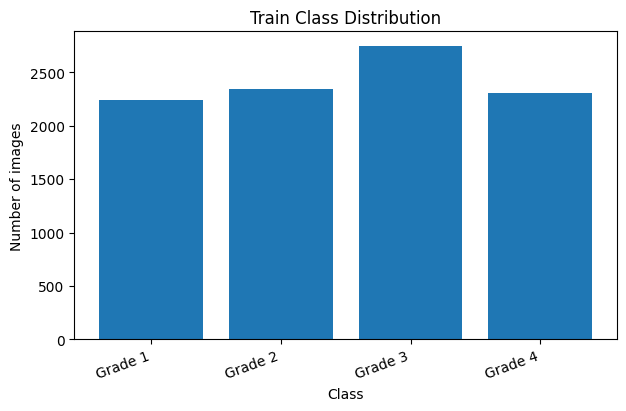

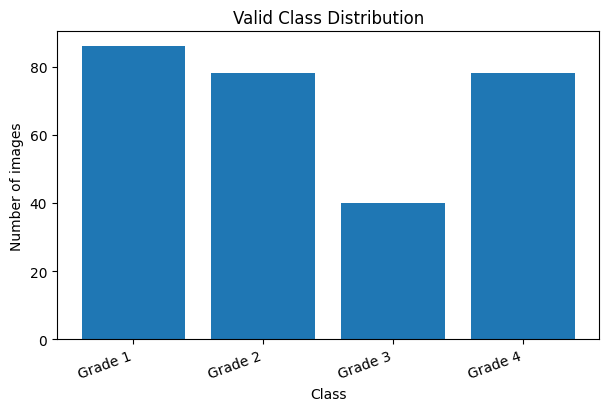

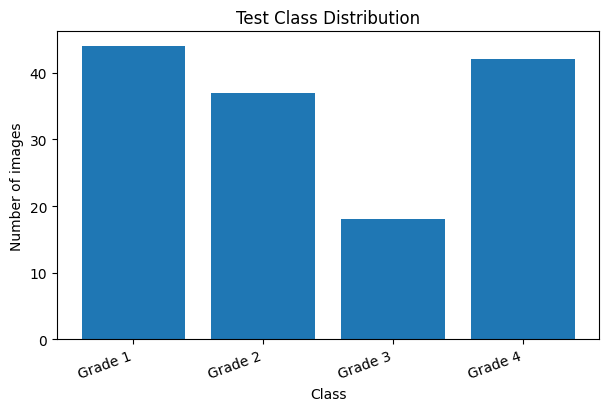

In [81]:
train_counts = loader.get_class_counts("train")
valid_counts = loader.get_class_counts("valid")
test_counts  = loader.get_class_counts("test")

def plot_counts(counts_dict, title):
    names = list(counts_dict.keys())
    vals = list(counts_dict.values())
    plt.figure(figsize=(7,4))
    plt.bar(names, vals)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.xticks(rotation=20, ha="right")
    plt.show()

plot_counts(train_counts, "Train Class Distribution")
plot_counts(valid_counts, "Valid Class Distribution")
plot_counts(test_counts,  "Test Class Distribution")


## 3. Visualize Raw Images (Without Preprocessing)

We will sample a few images from each class to verify:
- labels match the folder name
- images are readable
- the dataset content looks correct


In [82]:
def read_rgb(path):
    """Load and convert image from BGR to RGB. Returns None if image cannot be read."""
    if not os.path.exists(path):
        print(f"Warning: Image file not found: {path}")
        return None
    try:
        img = cv2.imread(path)
        if img is None:
            print(f"Warning: Failed to read image at {path}")
            return None
        if len(img.shape) != 3 or img.shape[2] != 3:
            print(f"Warning: Image {path} is not 3-channel: {img.shape}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        print(f"Error reading image {path}: {e}")
        return None

def show_image_grid(paths, titles=None, ncols=5, figsize=(12,6)):
    n = len(paths)
    nrows = int(np.ceil(n / ncols))
    plt.figure(figsize=figsize)
    for i, p in enumerate(paths):
        img = read_rgb(p)
        if img is None:
            continue
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Showing 5 raw samples for: Grade 1


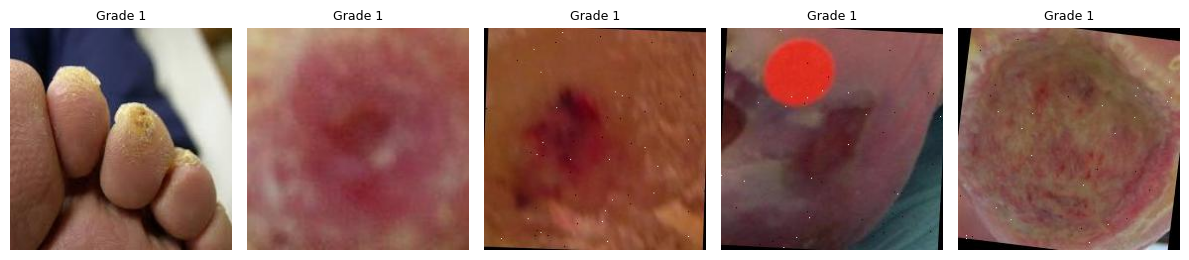

Showing 5 raw samples for: Grade 2


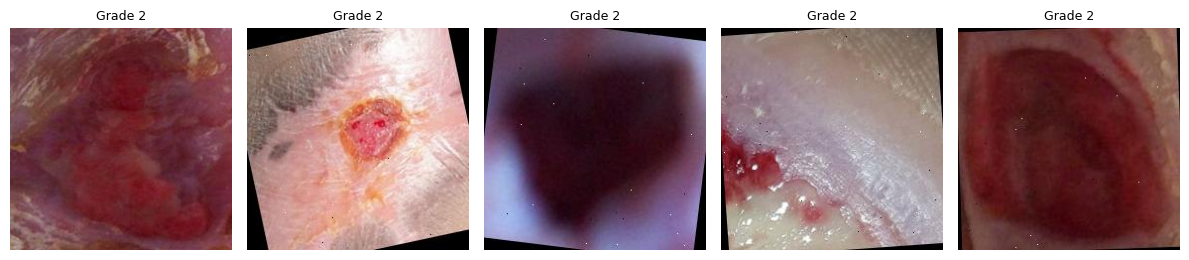

Showing 5 raw samples for: Grade 3


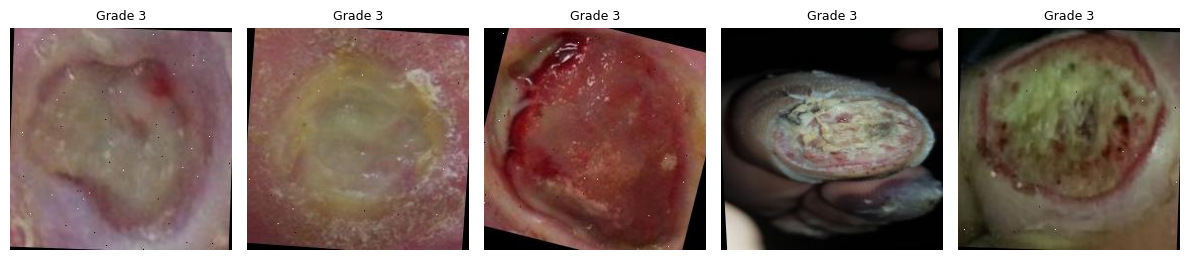

Showing 5 raw samples for: Grade 4


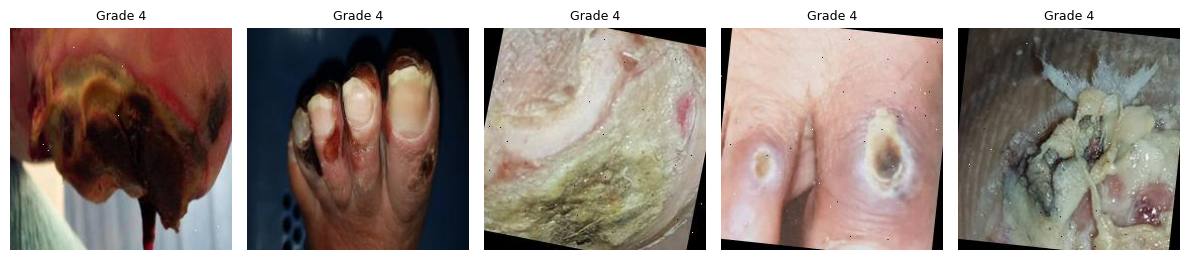

In [83]:
# Build a quick index: class -> list of paths
class_to_paths = {c: [] for c in classes}
for p, y in zip(X_train, y_train):
    class_to_paths[classes[int(y)]].append(p)

# Show samples per class
samples_per_class = 5
for c in classes:
    picks = random.sample(class_to_paths[c], k=min(samples_per_class, len(class_to_paths[c])))
    titles = [c] * len(picks)
    print(f"Showing {len(picks)} raw samples for: {c}")
    show_image_grid(picks, titles=titles, ncols=5, figsize=(12,3))


## 4. Define Preprocessing Transforms (Train vs Eval)

The model targets real-world patient-captured images. Augmentations simulate clinical and home-capture variability while preserving diagnostic features.

In [ ]:
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.05, hue=0.02),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

## 5. Visualize Augmentation (Before vs After)

Because we normalize tensors, we must **unnormalize** to visualize them properly.

We will:
- pick one sample image
- apply the train transform multiple times
- compare augmented outputs


In [85]:
def unnormalize_tensor(x, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """
    x: torch.Tensor (3,H,W) normalized
    returns: tensor in [0,1] range for visualization
    """
    mean_t = torch.tensor(mean).view(3,1,1)
    std_t  = torch.tensor(std).view(3,1,1)
    x_vis = (x * std_t + mean_t).clamp(0,1)
    return x_vis

def show_before_after_aug(path, transform, n_variants=5, title=""):
    # Original
    img = read_rgb(path)
    if img is None:
        print(f"Error: Could not read image at: {path}")
        return

    try:
        pil_img = Image.fromarray(img)
    except Exception as e:
        print(f"Error converting to PIL: {e}")
        return

    plt.figure(figsize=(14, 3))
    # Original
    plt.subplot(1, n_variants+1, 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # Variants
    for i in range(n_variants):
        try:
            x = transform(pil_img)                 # normalized tensor
            # Validate tensor range
            if x.min() < -5 or x.max() > 5:
                print(f"Warning: Tensor range [{x.min():.2f}, {x.max():.2f}] is unusual")
            x_vis = unnormalize_tensor(x)          # back to [0..1]
            plt.subplot(1, n_variants+1, i+2)
            plt.imshow(x_vis.permute(1,2,0).numpy())
            plt.title(f"Aug {i+1}")
            plt.axis("off")
        except Exception as e:
            print(f"Error in augmentation {i+1}: {e}")
            continue

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

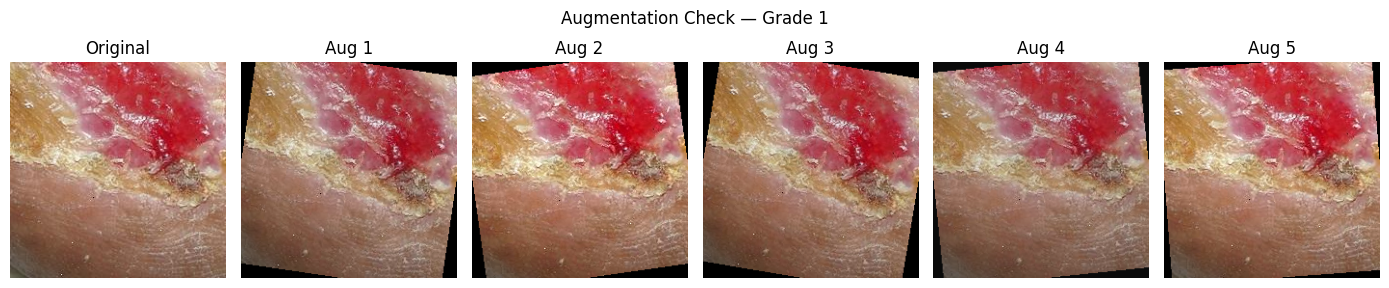

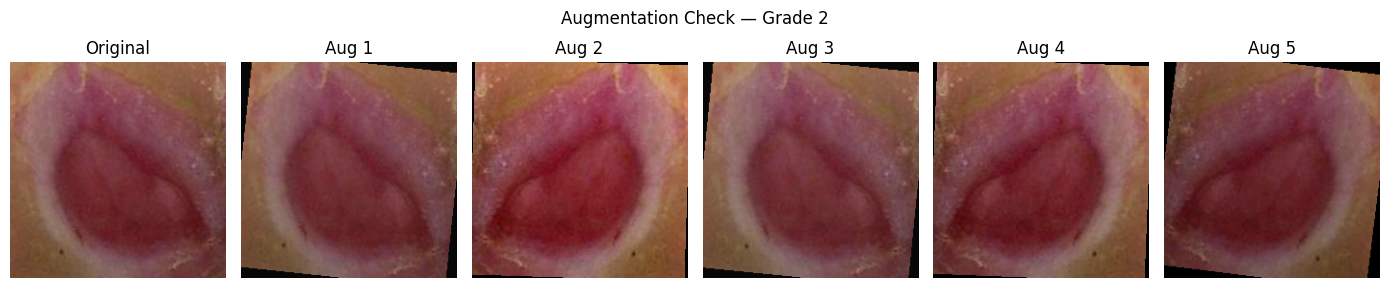

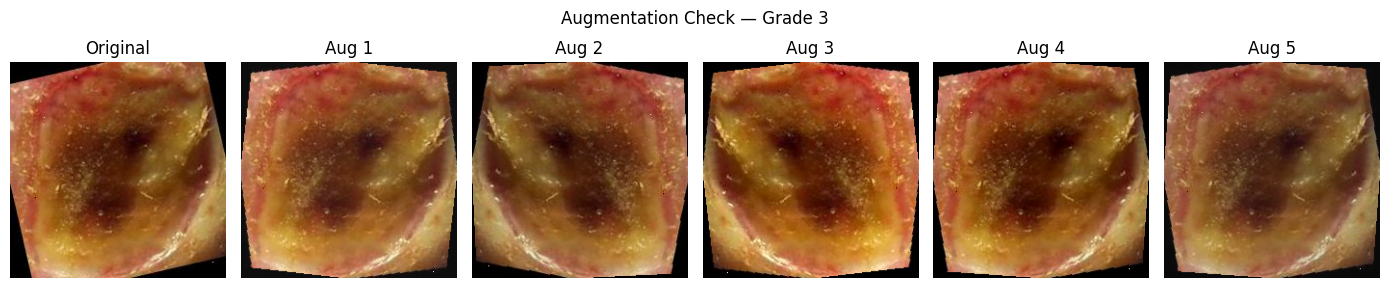

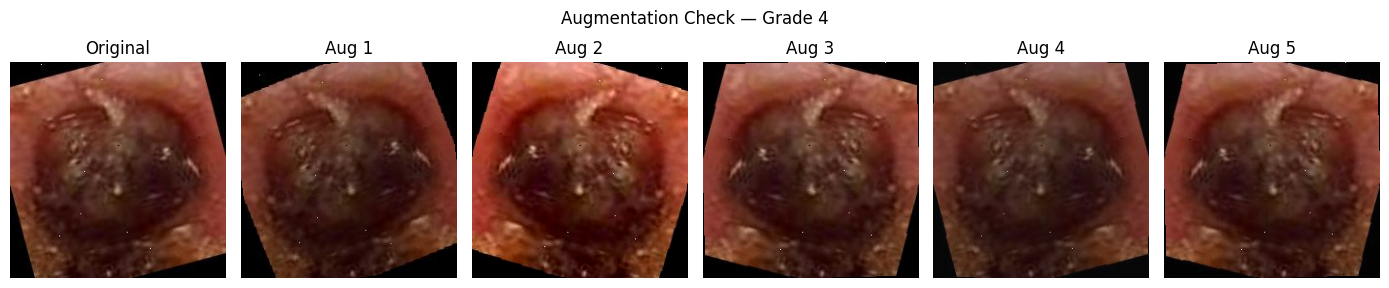

In [86]:
# Pick one example from each class and visualize augmentation effect
for c in classes:
    if not class_to_paths[c]:
        print(f"Skipping class '{c}' — no samples available")
        continue
    example_path = class_to_paths[c][0]
    show_before_after_aug(
        example_path,
        transform=train_tfms,
        n_variants=5,
        title=f"Augmentation Check — {c}"
    )

## Summary

### Dataset Overview
We're working with **9,639 training images** across 4 Wagner grades (1-4), with 282 validation and 141 test images. Class distribution is well-balanced (~1.2:1 ratio), so no oversampling needed.

### Preprocessing Pipeline

The model targets real-world patient-captured images. The following augmentations were applied to simulate clinical and home-capture variability:

**Training Augmentation:**
- **Resize to 224×224** — standard input for pretrained CNNs
- **Random horizontal flip (p=0.5)** — accounts for left/right foot orientation
- **Random vertical flip (p=0.3)** — simulates various shooting positions
- **Random rotation (±15°)** — simulates camera angle variation
- **Color jitter** (brightness=0.2, contrast=0.2, saturation=0.05, hue=0.02) — simulates lighting conditions
- **Gaussian blur** (σ=0.1–0.5) — simulates focus variance and motion blur
- **ImageNet normalization** — required for transfer learning

**Validation/Test:** Resize and normalization only (no augmentation).

### What We Avoided
Aggressive spatial transforms (scaling, translation) were excluded to prevent cropping of ulcer regions. Preserving diagnostic features was prioritized over augmentation diversity.

### Research Backing
This pipeline aligns with published DFU classification methods:
- Transfer learning with ImageNet normalization is standard practice
- Color augmentation simulates clinical lighting variance
- Flipping and rotation simulate various shooting locations
- Conservative spatial transforms protect diagnostic features

**Sources:**
- [A few-shot DFU image classification method - Nature 2024](https://www.nature.com/articles/s41598-024-80691-w)
- [A Deep Learning Approach for DFU Classification and Recognition - MDPI 2023](https://www.researchgate.net/publication/366994001_A_Deep_Learning_Approach_for_Diabetic_Foot_Ulcer_Classification_and_Recognition)

### Status
✓ Dataset loaded and verified  
✓ Preprocessing designed for patient camera use  
✓ Ready for model training